In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('/content/mnist_train.csv')
data = np.array(data)

In [ ]:
data = np.array(data)
m, _ = data.shape
np.random.shuffle(data) # shuffle data

X_test = data[:1000, 1:] / 255. # split data b/w train and test, and rescale
Y_test = data[:1000, 0]

X_train = data[1000:m, 1:] / 255.
Y_train = data[1000:m, 0]

0


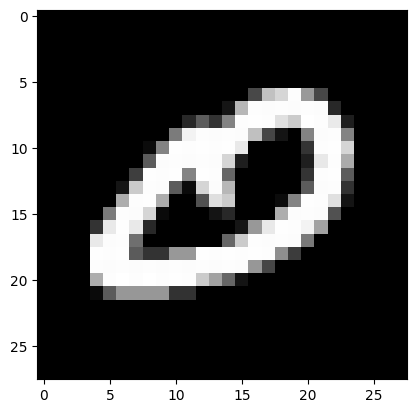

In [ ]:
img = np.reshape(X_train[1], (28,28)) # visualize a data point and its label
plt.imshow(img, cmap = 'gray')
print(Y_train[1])

In [ ]:
Y_train

array([8, 0, 0, ..., 2, 8, 1])

In [ ]:
def relu(Z):
  """
  inputs:
    Z (ndarray (m, n)): 2D array of raw output from weights and biases

  outputs:
    A (ndarray (m, n)): 2D array of only positive values in Z
  """

  A = np.maximum(Z, 0)

  return A

In [ ]:
def relu_deriv(Z):
  """
  inputs:
    Z (ndarray (m, n)): 2D array of raw output from weights and biases

  outputs:
    z_deriv (ndarray (m, n)): 2D array w/value 1 where Z >= 0 and value 0 where z < 0
  """

  Z_deriv = (Z >= 0)

  return Z_deriv

In [ ]:
def softmax(Z):
  """
  inputs:
    Z (ndarray (m, n)): 2D array of raw output from weights and biases

  outputs:
    A (ndarray (m, n)): 2D array where each value is e^z / sum(e^z of the row)

  notes:
    transposed twice because of trouble with numpy broadcasting
  """

  Z = Z.T
  A = np.exp(Z) / sum(np.exp(Z))
  A = A.T

  return A

In [ ]:
def one_hot(Y):
  """
  inputs:
    Y (ndarray (m, 1)): column matrix of true labels

  outputs:
    one_hot_y (ndarray (m, 10)): 2D matrix where each row is an example, the column with a 1 is the label, and the rest are 0's
  """

  one_hot_Y = np.zeros((Y.size, np.max(Y) + 1)) # zero matrix with rows same as Y, (9+1) = 10 columns
  one_hot_Y[np.arange(Y.size), Y] = 1 # for each row, set a 1 at the index with the label

  return one_hot_Y

In [ ]:
def init_network():
  """
  inputs:

  outputs:
    W1 (ndarray (784, 16)): matrix of weights for transformation from hidden layer to layer 1
    B1 (ndarray (1, 16)): column matrix of biases for transformation from hidden layer to layer 1
    W2 (ndarray (16, 10)): matrix of weights for transformation from layer 1 to layer 2
    B2 (ndarray (1, 10)): column matrix of biases for transformation from layer 1 to layer 2
  """

  W1 = np.random.rand(784, 16) - 0.5 # create random weight matrices corresponding to layers [784, 16, 10]
  W2 = np.random.rand(16,10) - 0.5

  B1 = np.random.rand(1, 16) - 0.5 # create random bias matrices corresponding to layers [784, 16, 10]
  B2 = np.random.rand(1, 10) - 0.5

  return W1, W2, B1, B2

In [ ]:
def forward_prop(X, W1, W2, B1, B2):
  """
  inputs:
    X (ndarray (m, 784)): each row is a training example, each column is a brightness intensity that makes up the image
    W1 (ndarray (784, 16)): matrix of weights for transformation from hidden layer to layer 1
    B1 (ndarray (1, 16)): column matrix of biases for transformatino from hidden layer to layer 1
    W2 (ndarray (16, 10)): matrix of weights for transformation from layer 1 to layer 2
    B2 (ndarray (1, 10)): column matrix of biases for transformatino from layer 1 to layer 2

  outputs:
    Z1 (ndarray (m, 16)): each row is a training example after first transformation and before activation, each column is a neuron in the first layer
    A1 (ndarray (m, 16)): each row is a training example after first transformation and activation, each column is a neuron in the first layer
    Z2 (ndarray (m, 10)): each row is a training example after second transformation and before activation, each column is a neuron in the second (output) layer
    A2 (ndarray (m, 10)): each row is a training example after second transformation and activation, each column is a neuron in the second (output) layer
  """

  Z1 = X.dot(W1) + B1 # apply forward prop formula to compute layer values before activation
  A1 = relu(Z1) # apply relu activation to first layer

  Z2 = A1.dot(W2) + B2
  A2 = softmax(Z2) # apply softmax activation to second layer

  return A1, A2, Z1, Z2

In [ ]:
def back_prop(X, Y, A1, A2, Z1, Z2, W1, W2, B1, B2):
  """
  inputs:
    X (ndarray (m, 784)): each row is a training example, each column is a brightness intensity that makes up the image
    Y (ndarray (m, 1)): column matrix of true labels
    Z1 (ndarray (m, 16)): each row is a training example after first transformation and before activation, each column is a neuron in the first layer
    A1 (ndarray (m, 16)): each row is a training example after first transformation and activation, each column is a neuron in the first layer
    Z2 (ndarray (m, 10)): each row is a training example after second transformation and before activation, each column is a neuron in the second (output) layer
    A2 (ndarray (m, 10)): each row is a training example after second transformation and activation, each column is a neuron in the second (output) layer
    W1 (ndarray (784, 16)): matrix of weights for transformation from hidden layer to layer 1
    B1 (ndarray (1, 16)): column matrix of biases for transformation from hidden layer to layer 1
    W2 (ndarray (16, 10)): matrix of weights for transformation from layer 1 to layer 2
    B2 (ndarray (1, 10)): column matrix of biases for transformation from layer 1 to layer 2

  outputs:
    dW1 (ndarray (784, 16)): adjustment weight matricex for W1
    dB1 (ndarray (1, 16)): adjustment bias matrices for B1
    dW2 (ndarray (16, 10)): adjustment weight matricex for W2
    dB2 (ndarray (1, 10)): adjustment bias matrices for B2
  """

  one_hot_Y = one_hot(Y) # encoding is done here in case you choose to shuffle the data/use batch Grad Desc for each iteration

  dZ2 = A2 - one_hot_Y # final layer dW and db have unique formula b/c softmax activation instead of relu
  dW2 = (1 / m) * ((A1.T).dot(dZ2))
  dB2 = (1 / m) * np.sum(dZ2, axis = 0)

  dZ1 = dZ2.dot(W2.T) * relu_deriv(Z1) # apply regular back prop formula
  dW1 = (1 / m) * (X.T).dot(dZ1)
  dB1 = (1 / m) * np.sum(dZ1, axis = 0)

  return dW1, dW2, dB1, dB2

In [ ]:
def update_params(W1, B1, W2, B2, dW1, dB1, dW2, dB2, alpha):
  """
  inputs:
    W1 (ndarray (784, 16)): matrix of weights for transformation from hidden layer to layer 1
    B1 (ndarray (1, 16)): column matrix of biases for transformation from hidden layer to layer 1
    W2 (ndarray (16, 10)): matrix of weights for transformation from layer 1 to layer 2
    B2 (ndarray (1, 10)): column matrix of biases for transformation from layer 1 to layer 2
    dW1 (ndarray (784, 16)): adjustment weight matricex for W1
    dB1 (ndarray (1, 16)): adjustment bias matrices for B1
    dW2 (ndarray (16, 10)): adjustment weight matricex for W2
    dB2 (ndarray (1, 10)): adjustment bias matrices for B2
    alpha (float): learning rate

  outputs:
    W1 (ndarray (784, 16)): matrix of weights for transformation from hidden layer to layer 1 after updating
    B1 (ndarray (1, 16)): column matrix of biases for transformation from hidden layer to layer 1 after updating
    W2 (ndarray (16, 10)): matrix of weights for transformation from layer 1 to layer 2 after updating
    B2 (ndarray (1, 10)): column matrix of biases for transformation from layer 1 to layer 2 after updating
  """

  W1 = W1 - alpha * dW1 # update each weight and bias matrix
  B1 = B1 - alpha * dB1
  W2 = W2 - alpha * dW2
  B2 = B2 - alpha * dB2

  return W1, B1, W2, B2

In [ ]:
def get_predictions(A2):
  """
  inputs:
    A2 (ndarray (m, 10)): last layer values after softmax

  outputs:
    predictions (ndarray (m, 1)): column matrix with predictions of label for each X
  """

  predictions = np.argmax(A2, axis = 1) # softmax returns probability of being a value, so highest probability is the label give by NN

  return predictions

In [ ]:
def get_accuracy(predictions, Y):
  """
  inputs:
    predictions (ndarray (m, 1)): column matrix with predictions of label for each X
    Y (ndarray (m, 1)): column matrix of true labels

  outputs:
    accuracy (float): number correct predictions / number total predictions
  """

  accuracy = np.sum(predictions == Y) / Y.size

  return accuracy

In [ ]:
def gradient_descent(X, Y, alpha, iterations):
  """
  inputs:
    X (ndarray (m, 784)): each row is a training example, each column is a brightness intensity that makes up the image
    Y (ndarray (m, 1)): column matrix of true labels
    alpha (float): learning rate
    iterations (int): number of times to run gradient descent over all of the data

  outputs:
    W1 (ndarray (784, 16)): trained matrix of weights for transformation from hidden layer to layer 1
    B1 (ndarray (1, 16)): trained column matrix of biases for transformation from hidden layer to layer 1
    W2 (ndarray (16, 10)): trained matrix of weights for transformation from layer 1 to layer 2
    B2 (ndarray (1, 10)): trained column matrix of biases for transformation from layer 1 to layer 2
    accuracy_list (list (1, iterations)): record of accuracy score for each iteration
    iterations_list (list (1, iterations)): record of iteration number for each iterations (list for consistency, np.arange would work fine)
  """

  W1, W2, B1, B2 = init_network()
  accuracy_list = [] # record accuracy v.s. iterations for visualizing data
  iterations_list = []

  for i in range(iterations+1):
    A1, A2, Z1, Z2 = forward_prop(X, W1, W2, B1, B2) # run gradient descent algorithm
    dW1, dW2, dB1, dB2 = back_prop(X, Y, A1, A2, Z1, Z2, W1, W2, B1, B2)
    W1, B1, W2, B2 = update_params(W1, B1, W2, B2, dW1, dB1, dW2, dB2, alpha)

    predictions = get_predictions(A2) # update accuracy and iterations lists
    accuracy = get_accuracy(predictions, Y)
    accuracy_list.append(accuracy)
    iterations_list.append(i)

    if i % 50 == 0: # visualize training while progress is continuing
      print("Iteration: ", i)
      print(predictions, Y)
      print(accuracy)

  return W1, B1, W2, B2, accuracy_list, iterations_list

In [ ]:
start = time.time()
W1, B1, W2, B2, accuracy_list, iterations_list = gradient_descent(X_train, Y_train, 0.1, 500)
print('total time taken to train: ', (time.time() - start))

Iteration:  0
[0 0 0 ... 0 9 6] [8 0 0 ... 2 8 1]
0.13734131086967577
Iteration:  50
[0 0 8 ... 2 5 1] [8 0 0 ... 2 8 1]
0.46107561145104153
Iteration:  100
[8 0 8 ... 2 5 1] [8 0 0 ... 2 8 1]
0.6572484279394566
Iteration:  150
[8 0 0 ... 2 8 1] [8 0 0 ... 2 8 1]
0.7439448126239427
Iteration:  200
[8 0 0 ... 2 8 1] [8 0 0 ... 2 8 1]
0.7889794742283768
Iteration:  250
[8 0 0 ... 2 8 1] [8 0 0 ... 2 8 1]
0.8156917913862947
Iteration:  300
[8 0 0 ... 2 8 1] [8 0 0 ... 2 8 1]
0.8321157985728571
Iteration:  350
[8 0 0 ... 2 8 1] [8 0 0 ... 2 8 1]
0.8430651366972322
Iteration:  400
[8 0 0 ... 2 8 1] [8 0 0 ... 2 8 1]
0.8531670028305565
Iteration:  450
[8 0 0 ... 2 8 1] [8 0 0 ... 2 8 1]
0.8603705147544873
Iteration:  500
[8 0 0 ... 2 8 1] [8 0 0 ... 2 8 1]
0.865963829895422


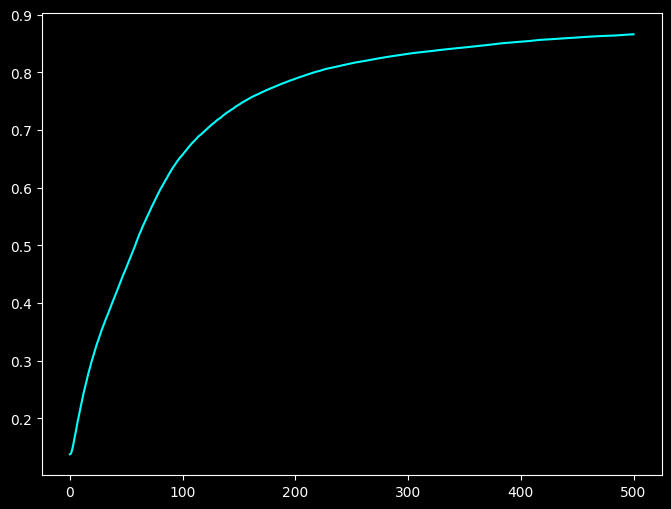

In [ ]:
plt.style.use('dark_background')  # Predefined style for black background
fig, ax = plt.subplots(1, 1, figsize = (8,6)) # define plot and set figure size
ax.plot(iterations_list, accuracy_list, color='cyan')
ax.set_ylim(0., 1.) # Set plot dimension
ax.set_xlim(0, 1000)
ax.set_yticks(np.arange(0, 1.1, 0.1))  # Set y-axis ticks at every 0.1 interval to 1.0
ax.set_xticks(np.arange(0, 1001, 100)) # Set x-axis ticks at every 100 interval to 1000
ax.set_ylabel('Accuracy', fontsize = 15)
ax.set_xlabel('Iteration', fontsize = 15)
ax.set_title('MNIST Neural Network Training Progress')
plt.show()

In [ ]:
A1, A2, Z1, Z2 = forward_prop(X_test, W1, W2, B1, B2) # apply trained weights and biases on test data
predictions = get_predictions(A2)
accuracy = get_accuracy(predictions, Y_test)
print(predictions[:5], Y_test[:5])
print(accuracy)

[6 6 0 4 7] [0 6 0 2 7]
0.87


prediction:  6 actual:  0


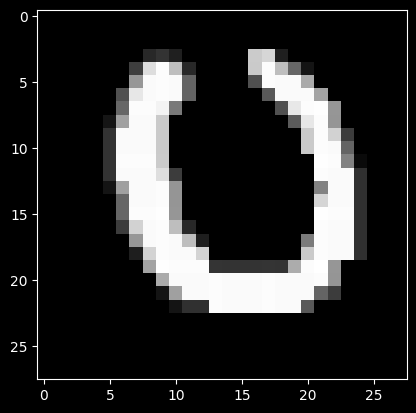

In [ ]:
img = np.reshape(X_test[0], (28,28)) # visualize results
plt.imshow(img, cmap = 'gray')
print('prediction: ', predictions[0], 'actual: ', Y_test[0])